<a href="https://colab.research.google.com/github/jssicaflores/predictive_model_project/blob/main/notebooks/donation_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install statsmodels

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX


In [2]:
from google.colab import files
uploaded = files.upload()


Saving data_science_for_fundraising_donor_data.csv to data_science_for_fundraising_donor_data (1).csv


In [3]:
df = pd.read_csv("data_science_for_fundraising_donor_data.csv")
df.head()


,ID,ZIPCODE,AGE,MARITAL_STATUS,GENDER,MEMBERSHIP_IND,ALUMNUS_IND,PARENT_IND,HAS_INVOLVEMENT_IND,WEALTH_RATING,...,CON_YEARS,PrevFYGiving,PrevFY1Giving,PrevFY2Giving,PrevFY3Giving,PrevFY4Giving,CurrFYGiving,TotalGiving,DONOR_IND,BIRTH_DATE
0,1,23187.0,NaN,Married,Female,N,N,N,N,NaN,...,1,$0,$0,$0,$0,$0,$0,10.0,Y,NaN
1,2,77643.0,33.0,NaN,Female,N,Y,N,Y,NaN,...,0,$0,$0,$0,$0,$0,$0,2100.0,Y,1984-06-16
2,3,NaN,NaN,Married,Female,N,N,N,N,NaN,...,1,$0,$0,$0,$0,$0,$200,200.0,Y,NaN
3,4,47141.0,31.0,NaN,Female,N,Y,N,Y,NaN,...,0,$0,$0,$0,$0,$0,$0,0.0,N,1986-12-03
4,5,92555.0,68.0,NaN,Female,N,N,N,N,NaN,...,0,$0,$0,$0,$0,$0,$0,505.0,Y,1949-09-11


In [4]:
#clean columns
giving_cols = [
    "CurrFYGiving",
    "PrevFYGiving",
    "PrevFY1Giving",
    "PrevFY2Giving",
    "PrevFY3Giving",
    "PrevFY4Giving"
]

def clean_money(x):
    if pd.isna(x):
        return 0
    x = str(x).replace("$", "").replace(",", "")
    return float(x) if x.strip() else 0

for col in giving_cols:
    df[col] = df[col].apply(clean_money)

df[giving_cols].head()


,CurrFYGiving,PrevFYGiving,PrevFY1Giving,PrevFY2Giving,PrevFY3Giving,PrevFY4Giving
0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0
2,200.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
#build annual time series
year_map = {
    "CurrFYGiving": 2014,
    "PrevFYGiving": 2013,
    "PrevFY1Giving": 2012,
    "PrevFY2Giving": 2011,
    "PrevFY3Giving": 2010,
    "PrevFY4Giving": 2009
}

yearly_list = []

for col, year in year_map.items():
    total = df[col].sum()
    yearly_list.append([year, total])

yearly_df = pd.DataFrame(yearly_list, columns=["year", "total_giving"])
yearly_df = yearly_df.sort_values("year")
yearly_df


,year,total_giving
5,2009,4369789.0
4,2010,1971056.0
3,2011,2200055.0
2,2012,3319706.0
1,2013,13030802.0
0,2014,6825497.0


In [6]:
#proper time index
ts = yearly_df.copy()
ts["date"] = pd.to_datetime(ts["year"].astype(str) + "-01-01")
ts = ts.set_index("date")
ts = ts[["total_giving"]]
ts


,total_giving
date,
2009-01-01,4369789.0
2010-01-01,1971056.0
2011-01-01,2200055.0
2012-01-01,3319706.0
2013-01-01,13030802.0
2014-01-01,6825497.0


In [8]:
# ARIMA model
model = SARIMAX(
    y,
    order=(1, 1, 1),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit(disp=False)
results.summary()


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/mlemodel.py:3160: UserWarning: Early subset of data for variable 0 has too few non-missing observations to calculate test statistic.
  test_statistic, p_value = breakvar_heteroskedasticity_test(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/mlemodel.py:3160: UserWarning: Late

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           total_giving   No. Observations:                    6
Model:               SARIMAX(1, 1, 1)   Log Likelihood           -38793579.324
Date:                Thu, 20 Nov 2025   AIC                       77587164.648
Time:                        02:49:13   BIC                       77587161.943
Sample:                    01-01-2009   HQIC                      77587159.212
                         - 01-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6264   1.28e-06   -4.9e+05      0.000      -0.626      -0.626
ma.L1        -38.9253      0.001  -3.36e+04      0.000     -38.928     -38.923
sigma2       940.9025      0.056   1.68e+04      0.000     940.793     941.012
===================================================================================
Ljung-Box (L1) (Q):                   3.27   Jarque-Bera (JB):                 0.51
Prob(Q):                              0.07   Prob(JB):                         0.77
Heteroskedasticity (H):                nan   Skew:                             0.68
Prob(H) (two-sided):                   nan   Kurtosis:                         1.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [11]:
n_forecast = 5
forecast = results.get_forecast(steps=n_forecast)

forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

forecast_index = pd.date_range(
    start=ts.index[-1] + pd.offsets.YearBegin(1),
    periods=n_forecast,
    freq="YS"
)

forecast_series = pd.Series(forecast_mean.values, index=forecast_index)
forecast_ci.index = forecast_index


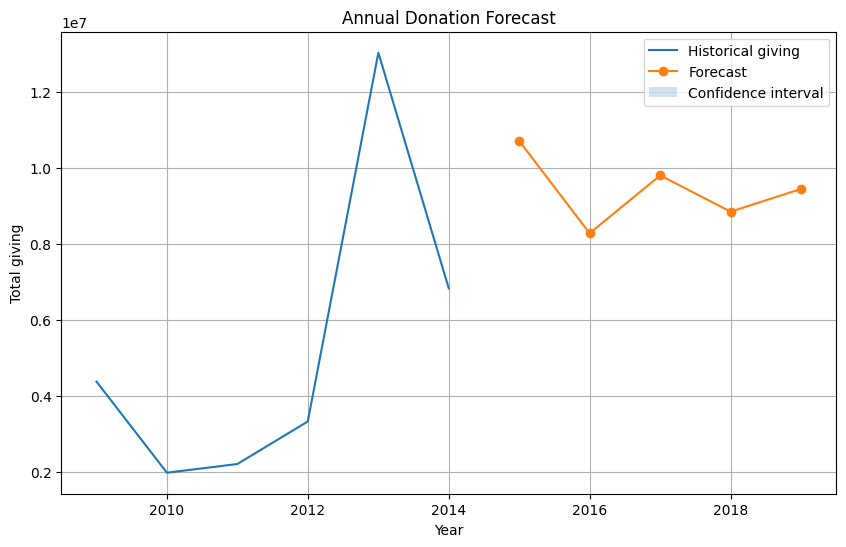

In [12]:
plt.figure(figsize=(10, 6))

# Historical
plt.plot(ts.index, ts["total_giving"], label="Historical giving")

# Forecast
plt.plot(forecast_series.index, forecast_series.values,
         label="Forecast", marker="o")

# Confidence interval band
plt.fill_between(
    forecast_ci.index,
    forecast_ci["lower total_giving"],
    forecast_ci["upper total_giving"],
    alpha=0.2,
    label="Confidence interval"
)

plt.title("Annual Donation Forecast")
plt.xlabel("Year")
plt.ylabel("Total giving")
plt.legend()
plt.grid(True)
plt.show()


In [13]:
combined = pd.concat(
    [ts["total_giving"], forecast_series.rename("forecast")],
    axis=0
)
combined


,0
2009-01-01,4.369789e+06
2010-01-01,1.971056e+06
2011-01-01,2.200055e+06
2012-01-01,3.319706e+06
2013-01-01,1.303080e+07
2014-01-01,6.825497e+06
2015-01-01,1.070873e+07
2016-01-01,8.276285e+06
2017-01-01,9.799960e+06
2018-01-01,8.845535e+06
